In [ ]:
#Imports
import openai
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import tiktoken
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings
openai.api_key = ""

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# WebCrawler

In [ ]:
# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "usa.gov" # <- put your domain to be crawled
full_url = "https://usa.gov/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [ ]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [ ]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [ ]:
#Url Crawl
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
        os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
        os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
        os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")

            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://usa.gov/
https://usa.gov/early-childhood
https://usa.gov/#all_topics
https://usa.gov/welfare-benefits
https://usa.gov/government-checks-payments
https://usa.gov/es/cheques-pagos-del-gobierno
https://usa.gov/es/ayuda-pagar-facturas
https://usa.gov/es/ayuda-pagar-luz-gas
https://usa.gov/es/enfrentar-dificultades-economicas
https://usa.gov/es/beneficios-desempleo
https://usa.gov/es/trabajo-desempleo
https://usa.gov/es/proteccion-trabajador-leyes-laborales
https://usa.gov/es/despido-terminacion-empleo
https://usa.gov/termination-of-employment
https://usa.gov/fmla
https://usa.gov/family-leave-act
https://usa.gov/es/fmla-responsabilidades-empleador
https://usa.gov/es/fmla-trabajadores
https://usa.gov/employer-fmla
https://usa.gov/wrongful-termination
https://usa.gov/report-safety-violations
https://usa.gov/job-search
https://usa.gov/job-help
https://usa.gov/es/buscar-trabajo
https://usa.gov/es/capacitacion-laboral
https://usa.gov/veteran-job-programs
https://usa.gov/military-pay-bene

KeyboardInterrupt: ignored

# Building Embeddings index

In [ ]:
#Removes newline characters and repeated spaces from each element in the Series
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie


In [ ]:
# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

<ipython-input-14-7660063ba737>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,itary tuition assistance,itary tuition assistance. Military tuition ...
1,ort safety violations,ort safety violations. Where to report work...
2,seguro social incapacidad discapacidad,seguro social incapacidad discapacidad. Ben...
3,ior food programs,ior food programs. Food assistance programs...
4,documentos historicos estados unidos,documentos historicos estados unidos. Docum...


<Axes: >

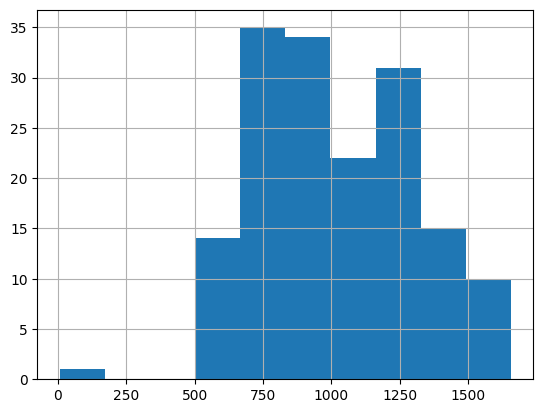

In [ ]:
# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [ ]:
#Set max tokens
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

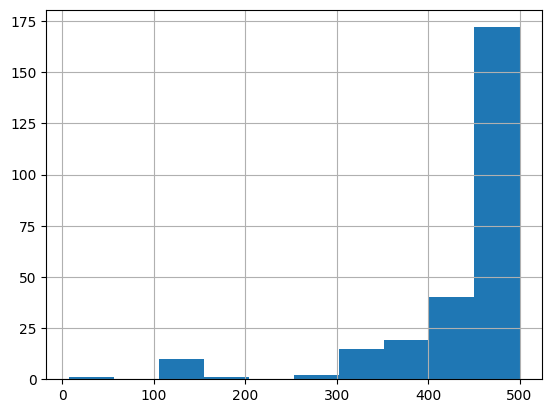

In [ ]:
#Create histogram of tokens
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [ ]:
#Create embeddings for the text in the df dataframe using Embedding API, save to a CSV file
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

,text,n_tokens,embeddings
0,itary tuition assistance. Military tuition ...,484,"[-0.005181129090487957, -0.010909026488661766,..."
1,ort safety violations. Where to report work...,392,"[0.003597257426008582, -0.024261029437184334, ..."
2,seguro social incapacidad discapacidad. Ben...,151,"[-0.007826055400073528, -0.01204974576830864, ..."
3,English Página principal Cerrar B...,474,"[-0.012513290159404278, -0.002807844430208206,..."
4,Aprenda cómo funcionan el SSDI y el SSI El S...,488,"[-0.006137838587164879, 1.5198689652606845e-05..."


In [ ]:
#Read in the CSV file 'processed/embeddings.csv', then convert embeddings from string to NumPy array
df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,itary tuition assistance. Military tuition ...,484,"[-0.005181129090487957, -0.010909026488661766,..."
1,ort safety violations. Where to report work...,392,"[0.003597257426008582, -0.024261029437184334, ..."
2,seguro social incapacidad discapacidad. Ben...,151,"[-0.007826055400073528, -0.01204974576830864, ..."
3,English Página principal Cerrar B...,474,"[-0.012513290159404278, -0.002807844430208206,..."
4,Aprenda cómo funcionan el SSDI y el SSI El S...,488,"[-0.006137838587164879, 1.5198689652606845e-05..."


In [ ]:
#Define create context
def create_context(
        question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():

        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4

        # If the context is too long, break
        if cur_len > max_len:
            break

        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

In [ ]:
#Create a Question Prompt
def answer_question(
        df,
        model="text-davinci-003",
        question="Is there a Coronavirus tax relief available for 2022 taxes?",
        max_len=1800,
        size="ada",
        debug=False,
        max_tokens=150,
        stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [ ]:
user_question = str(input("Ask a Question about {website}".format(website = domain)))
print(user_question)
answer_question(df,question = user_question)

Ask a Question about usa.govWhat are the tax updates from the IRS?
What are the tax updates from the IRS?


'The IRS has released a new tax filing form for people 65 and older. It is an easier-to-read version of the 1040 form. It has bigger print, less shading, and features like a standard deduction chart. The form is optional and uses the same schedules, instructions, and attachments as the regular 1040.'

In [ ]:
user_question2 = str(input("Ask a Question about {website}".format(website = domain)))
print(user_question2)
answer_question(df,question = user_question2)

Ask a Question about usa.govWhen is the deadline to file taxes?
When is the deadline to file taxes?


'April 18, 2023'

In [ ]:
user_question3 = str(input("Ask a Question about {website}".format(website = domain)))
print(user_question3)
answer_question(df,question = user_question3)

Ask a Question about usa.govWhat are the qualifications for the Corona Tax Relief?
What are the qualifications for the Corona Tax Relief?


'The IRS offers tax relief to those affected by federally declared disasters. If you are a disaster survivor, you may qualify for a tax-filing extension or expedited tax refund.'

In [ ]:
user_question4 = str(input("Ask a Question about {website}".format(website = domain)))
print(user_question4)
answer_question(df,question = user_question4)

Ask a Question about usa.gov how do you resolve a tax dispute with the IRS?
 how do you resolve a tax dispute with the IRS?


"I don't know."

In [ ]:
user_question5 = str(input("Ask a Question about {website}".format(website = domain)))
print(user_question5)
answer_question(df,question = user_question5)

Ask a Question about usa.govHow do I file a tax return if I am a non-resident?
How do I file a tax return if I am a non-resident?


"Filing a federal tax return if you are a nonresident alien | USAGov             Skip to main content    An official website of the United States government Here's how you know Here's how you know   The .gov means itâ\x80\x99s official.    Federal government websites often end in .gov or .mil. Before sharing sensitive information, make sure youâ\x80\x99re on a federal government site.     The site is secure.    The https:// ensures that you are connecting to the official website and that any information you provide is encrypted and transmitted securely.       EspaÃ±ol   Home   Close    Search   1-844-USAGOV1  Taxes Filing federal taxes  Do you"

In [ ]:
user_question6 = str(input("Ask a Question about {website}".format(website = domain)))
print(user_question6)
answer_question(df,question = user_question6)

Ask a Question about usa.govPlease answer in English, how do you resolve a tax dispute with the IRS?
Please answer in English, how do you resolve a tax dispute with the IRS?


'If you have a tax dispute with the IRS, there are ways you can resolve it. You can get help with the Taxpayer Advocate Service (TAS), which is a free service that helps you resolve tax problems. You can also contact a Low-Income Taxpayer Clinic (LITC) for free or low-cost services. You can also appeal to the IRS Office of Appeals or contact the IRS Centralized Lien Operation.'

# Experimenting

In [ ]:
#English only motified

def answer_question_modified(
        df,
        model="text-davinci-003",
        # Set the language-specific model
        model_engine="text-davinci-002", # English by default
        language_code="en", # English language code
        question="Am I allowed to publish model outputs to Twitter, without a human review?",
        max_len=1800,
        size="ada",
        debug=False,
        max_tokens=150,
        stop_sequence=None,
        user_id=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context and use google if it cannot find the answer
        response1 = openai.Completion.create(
            prompt=f"Answer the question based on the context below and say you are using the context below, and if the question can't be answered based on the context use the google \"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )

        response2 = openai.Completion.create(
            engine=model_engine,
            prompt=question,
            max_tokens=max_tokens,
            n=1,
            stop=None,
            temperature=0.7,
            frequency_penalty=0,
            presence_penalty=0,
            user=user_id,
            model=model_engine+"/"+language_code # Set the language-specific model
        ) 

        response = response1.choices[0].text.strip() + "\n" + response2.choices[0].text.strip()
        return response
    except Exception as e:
        print(e)
        return ""


In [ ]:
user_question7 = str(input("Ask a Question about {website}".format(website = domain)))
print(user_question7)
answer_question_modifed(df,question = user_question7)

NameError: ignored